In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from src.regressor import Flip7Model
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from src.flip7_game import Flip7Game
from src.train_regressor import create_dataset, train, evaluate

In [14]:
# Pick a comfortable color palette
colors = sns.color_palette("muted", 3)
ds: TensorDataset = create_dataset(5000)
ds_test: TensorDataset = create_dataset(1000)

Generating dataset: 100%|██████████| 1000/1000 [00:18<00:00, 52.75it/s]


In [15]:
# Example model definition
model = Flip7Model()
train(model, ds, ds_test, 30, 128, 0.01)
torch.save(model.state_dict(), "models/model.pt")

# Collect predictions
data_loader = DataLoader(ds_test, shuffle=False, batch_size=32)
predictions = []
with torch.no_grad():
    for batch in data_loader:
        in_data, _ = batch
        prediction = model(in_data)
        predictions.append(prediction)
predictions = torch.cat(predictions, dim=0).squeeze().numpy()

Epoch   1 | Train Loss: 1.986319
Epoch   2 | Train Loss: 1.420514
Epoch   3 | Train Loss: 1.238774
Epoch   4 | Train Loss: 1.194712
Epoch   5 | Train Loss: 1.205918 | Test Loss: 0.881877
Epoch   6 | Train Loss: 1.072392
Epoch   7 | Train Loss: 1.093570
Epoch   8 | Train Loss: 1.100343
Epoch   9 | Train Loss: 1.013330
Epoch  10 | Train Loss: 1.077879 | Test Loss: 0.874129
Epoch  11 | Train Loss: 1.100936
Epoch  12 | Train Loss: 1.048974
Epoch  13 | Train Loss: 0.978258
Epoch  14 | Train Loss: 0.953252
Epoch  15 | Train Loss: 0.956830 | Test Loss: 0.709102
Epoch  16 | Train Loss: 0.931298
Epoch  17 | Train Loss: 1.046294
Epoch  18 | Train Loss: 1.062376
Epoch  19 | Train Loss: 0.945243
Epoch  20 | Train Loss: 1.086984 | Test Loss: 0.684166
Epoch  21 | Train Loss: 0.986788
Epoch  22 | Train Loss: 0.975603
Epoch  23 | Train Loss: 1.077166
Epoch  24 | Train Loss: 0.980693
Epoch  25 | Train Loss: 1.014301 | Test Loss: 0.627373
Epoch  26 | Train Loss: 0.994242
Epoch  27 | Train Loss: 0.928253

## Compare predictions with labels

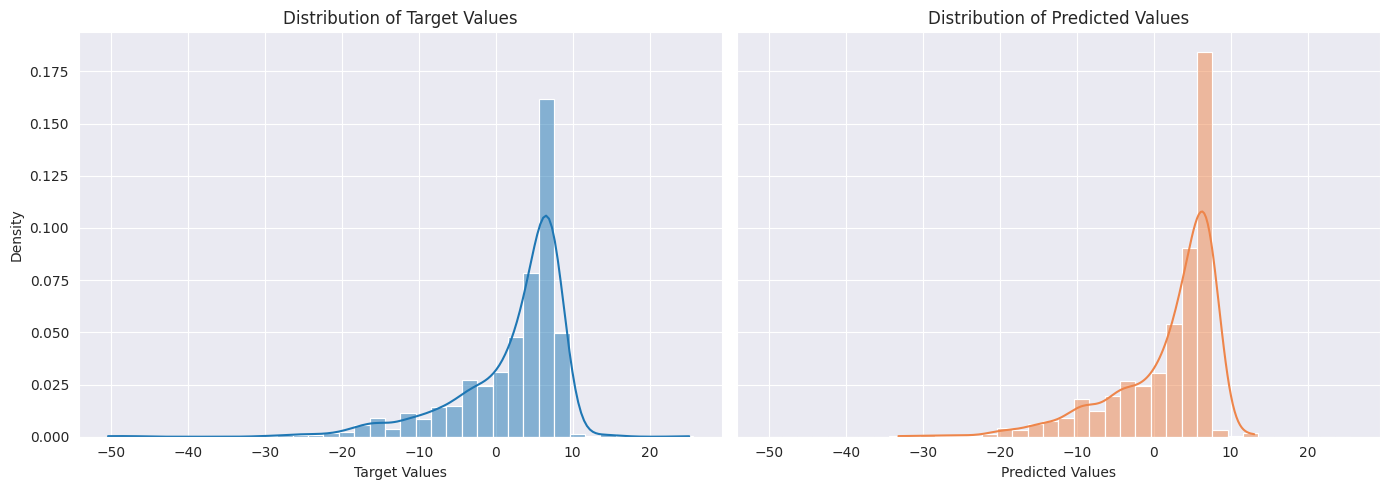

In [16]:
# Convert to 1D numpy array
targets = ds_test.tensors[1].numpy()

# Determine global x-axis range
x_min = min(targets.min(), predictions.min())
x_max = max(targets.max(), predictions.max())

# Define consistent bins
bin_width = 2.0
bins = np.arange(x_min, x_max + bin_width, bin_width)

# Create figure with 2 subplots
_, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

# Plot target values
sns.histplot(targets, bins=bins, kde=True, stat='density', color=colors[0], ax=axes[0], legend=False)
axes[0].set_title('Distribution of Target Values')
axes[0].set_xlabel('Target Values')
axes[0].set_ylabel('Density')

# Plot predictions
sns.histplot(predictions, bins=bins, kde=True, stat='density', color=colors[1], ax=axes[1], legend=False)
axes[1].set_title('Distribution of Predicted Values')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()


## Compare different policies

In [17]:
def mc_sampling_agent(game: Flip7Game):
    """
    Approximate expected score difference through MC sampling
    :param game: game instance
    :return: True iff agent stays in
    """
    expected_value = game.mc_sample_expected_score_difference_of_in(200)
    return True if expected_value > 0 else False

def learned_mc_sampling_agent(game: Flip7Game):
    """
    Query model that was trained to reproduce expected score difference through MC sampling
    :param game: game instance
    :return: True iff agent stays in
    """
    obs = np.array([game.card_counts_in_hand[c] for c in Flip7Game.CARD_TYPES], dtype=np.float32)
    observation = torch.tensor(obs).unsqueeze(0)
    expected_value = model(observation).item()
    return True if expected_value > 0 else False

def always_in(_: Flip7Game):
    """
    Baseline agent that always stays in
    :param _: game instance
    :return: True
    """
    return True

def in_if_below_30(game: Flip7Game):
    """
    Baseline agent that always stays in until it reaches a score of 30 then its out.
    :param game: game instance
    :return: True iff agent stays in
    """
    if game.score > 30 and not game.has_second_chance:
        return False
    return True

In [18]:
round_rewards_baseline = evaluate(mc_sampling_agent)
round_rewards_model = evaluate(learned_mc_sampling_agent)
round_rewards_luca = evaluate(always_in)
round_rewards_luca2 = evaluate(in_if_below_30)

100%|██████████| 1000/1000 [00:19<00:00, 50.74it/s]


Evaluation complete: 
	Avg score per move: 4.76
	Avg score per round: 21.60


100%|██████████| 1000/1000 [00:00<00:00, 4502.14it/s]


Evaluation complete: 
	Avg score per move: 4.81
	Avg score per round: 19.68


100%|██████████| 1000/1000 [00:00<00:00, 135086.61it/s]


Evaluation complete: 
	Avg score per move: 1.88
	Avg score per round: 9.48


100%|██████████| 1000/1000 [00:00<00:00, 121517.67it/s]

Evaluation complete: 
	Avg score per move: 3.56
	Avg score per round: 17.04


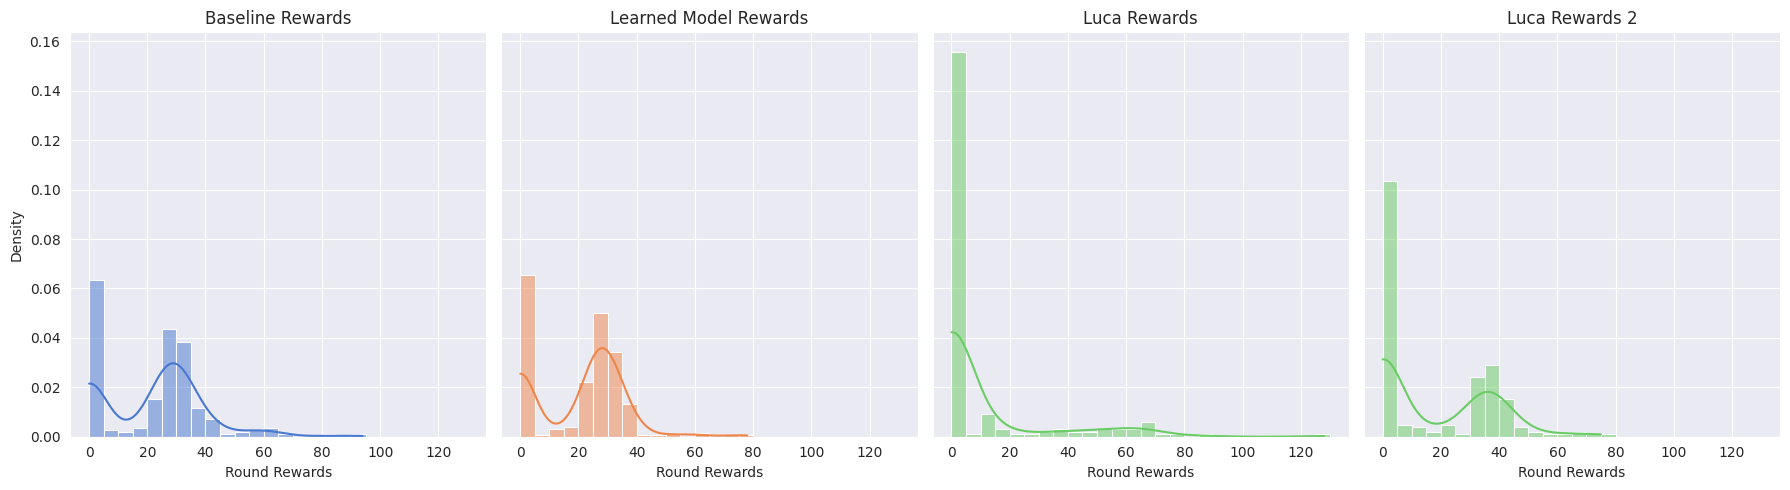

In [19]:
# Convert rewards to numpy arrays
round_rewards_baseline = np.array(round_rewards_baseline)
round_rewards_model = np.array(round_rewards_model)
round_rewards_luca = np.array(round_rewards_luca)
round_rewards_luca2 = np.array(round_rewards_luca2)

# Determine global x-axis range
x_min = min(round_rewards_baseline.min(), round_rewards_model.min(), round_rewards_luca.min())
x_max = max(round_rewards_baseline.max(), round_rewards_model.max(), round_rewards_luca.max())

# Define consistent bins
bin_width = 5.0
bins = np.arange(x_min, x_max + bin_width, bin_width)

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharex=True, sharey=True)

# Plot Baseline
sns.histplot(round_rewards_baseline, bins=bins, kde=True, stat='density', color=colors[0], ax=axes[0])
axes[0].set_title('Baseline Rewards')
axes[0].set_xlabel('Round Rewards')
axes[0].set_ylabel('Density')

# Plot Learned Model
sns.histplot(round_rewards_model, bins=bins, kde=True, stat='density', color=colors[1], ax=axes[1])
axes[1].set_title('Learned Model Rewards')
axes[1].set_xlabel('Round Rewards')
axes[1].set_ylabel('Density')

# Plot Luca
sns.histplot(round_rewards_luca, bins=bins, kde=True, stat='density', color=colors[2], ax=axes[2])
axes[2].set_title('Luca Rewards')
axes[2].set_xlabel('Round Rewards')
axes[2].set_ylabel('Density')

# Plot Luca 2
sns.histplot(round_rewards_luca2, bins=bins, kde=True, stat='density', color=colors[2], ax=axes[3])
axes[3].set_title('Luca Rewards 2')
axes[3].set_xlabel('Round Rewards')
axes[3].set_ylabel('Density')

# Align y-axis limits
max_y = max(
    axes[0].get_ylim()[1],
    axes[1].get_ylim()[1],
    axes[2].get_ylim()[1]
)
for ax in axes:
    ax.set_ylim(0, max_y)

plt.tight_layout()
plt.show()